# Regression Models for Flight Fare Prediction

## 1. Objective
This notebook implements and optimizes **Ridge** and **Lasso regression** and **basic polynomial regression** models to predict `baseFare` for flights. The models are combined with polynomial feature engineering to capture non-linear relationships in the data.

## Model Selection Rationale

### Why Ridge and Lasso?
- **Ridge Regression (L2 regularization)**: Shrinks coefficients but keeps all features, useful when many features are potentially relevant
- **Lasso Regression (L1 regularization)**: Performs automatic feature selection by setting some coefficients to exactly zero, providing built-in sparsity
- **Polynomial Features**: Allow linear models to capture non-linear relationships (e.g., quadratic effects of booking lead time on price)
- **Regularization**: Critical for high-dimensional polynomial feature spaces to prevent overfitting

### Why NOT Local and Isotonic Regression?

**Local Regression**:
- Computationally expensive for large datasets (non-parametric, requires storing training data)
- Does not scale well with high-dimensional feature spaces
- Difficult to interpret and explain compared to parametric models
- Not suitable for datasets with many binary/categorical features like ours

**Isotonic Regression**:
- Only works with **single-variable** monotonic relationships (univariate)
- Our problem has **multiple features** that interact in complex ways
- Cannot handle multi-dimensional feature spaces
- Would require building separate models for each feature, losing interaction effects

Our dataset has **continuous features** (seats remaining, booking lead time, travel duration, departureTime) and **many binary features** (one-hot encoded airports and airlines). Ridge and Lasso naturally handle this mixed feature space and high dimensionality.

## 2. Import Required Libraries
Loading necessary packages for:
- Data manipulation (`pandas`, `numpy`)
- Feature engineering (`PolynomialFeatures`, scalers)
- Model construction (`Ridge`, `Lasso`, `LinearRegression`, `Pipeline`)
- Hyperparameter optimization (`Optuna` for Bayesian search)
- Evaluation metrics (MSE, RMSE, MAE, R-squared)
- Visualization (`matplotlib`) and persistence (`pickle`)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import pickle
from collections import OrderedDict
from IPython.display import display
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
import os
import warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)


## 3. Data Loading and Feature Separation

### Feature Engineering Strategy
We separate features into two categories based on their transformation needs:

**Continuous Features** (treated numerically for polynomial expansion):
- `seatsRemaining`: Inventory pressure indicator
- `Booking Lead Time`: Days until departure (critical pricing factor)
- `travelDuration_minutes`: Flight duration
- `departureTime_sin`, `departureTime_cos`: Cyclical encoding of departure time

These undergo **polynomial transformation** to capture non-linear effects (e.g., diminishing returns of more seats).

**Binary / One-Hot Features**:
- `elapsedDays`, `isBasicEconomy`
- One-hot encoded airports, airlines, and day-of-week

Binary features are **passed through unchanged** since they don't benefit from polynomial expansion and expanding them would cause a combinatorial explosion.


In [18]:
train_data = pd.read_csv('data/train_data.csv')
target_column = 'baseFare'



continuous_cols = [
    'seatsRemaining',          
    'Booking Lead Time',           
    'travelDuration_minutes',     
    'departureTime_sin',         
    'departureTime_cos'
]

binary_base_cols = ['isBasicEconomy', 'elapsedDays']
one_hot_prefixes = ['startingAirport_', 'destinationAirport_', 'segmentsAirlineName_', 'dayOfWeek_']
one_hot_cols = [c for c in train_data.columns if any(c.startswith(p) for p in one_hot_prefixes)]

binary_cols = binary_base_cols + one_hot_cols

X_train = train_data[continuous_cols + binary_cols]
y_train = train_data[target_column]

print(f"Continuous Features: {len(continuous_cols)} -> {continuous_cols}")
print(f"Binary Features:     {len(binary_cols)} (base={binary_base_cols}, one-hot count={len(one_hot_cols)})")
print(f"Total Samples:       {len(X_train)}")


Continuous Features: 5 -> ['seatsRemaining', 'Booking Lead Time', 'travelDuration_minutes', 'departureTime_sin', 'departureTime_cos']
Binary Features:     44 (base=['isBasicEconomy', 'elapsedDays'], one-hot count=42)
Total Samples:       125668


## 4. Feature Dimensionality Check

This cell validates the feature space size for high polynomial degrees. With degree 5:
- Continuous features generate many polynomial combinations (including interactions)
- Binary features remain unchanged
- Total feature count can grow significantly, making regularization essential

Understanding feature explosion guides limits on polynomial degree and motivates L1/L2 penalties. It also explains why we didn't include higher degree polynomials in hyperparameter optimization since it would lead to high computational costs and the risk of overfitting.


In [19]:
poly_check = PolynomialFeatures(degree=5, include_bias=False)
poly_check.fit(X_train[continuous_cols].iloc[:5])

n_poly_out = poly_check.n_output_features_
n_binary = len(binary_cols)
total_features = n_poly_out + n_binary

print(f"Checking features for degree of 5")
print(f"Poly-Features (from {len(continuous_cols)} Numbers): {n_poly_out}")
print(f"Binary-Features (aren't transformed):  {n_binary}")
print(f"Total features Model:               {total_features}")

Checking features for degree of 5
Poly-Features (from 5 Numbers): 251
Binary-Features (aren't transformed):  44
Total features Model:               295


## 5. Pipeline Factory Function

Creates a full preprocessing + modeling pipeline with configurable:
- **Scaler**: `StandardScaler` vs `RobustScaler`
- **Polynomial degree**: Non-linearity depth
- **Model type**: Ridge (L2 keeps all features) vs Lasso (L1 induces sparsity) vs later OLS (basic polynomial regression)
- **Alpha**: Regularization strength

### Structure
1. ColumnTransformer
   - Continuous -> Pre-scale -> PolynomialFeatures -> Post-scale
   - Binary / one-hot -> passthrough
2. Estimator (Ridge/Lasso)

Pre-scaling helps avoid extreme intermediate magnitudes that can destabilize polynomial expansion.


In [20]:
def create_model_pipeline(scaler_type, poly_degree, model_type, alpha, random_state=1):
    prescaler = StandardScaler()  
    postscaler = StandardScaler() if scaler_type == 'standard' else RobustScaler()

    numeric_transformer = Pipeline([
        ('prescaler', prescaler),
        ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
        ('postscaler', postscaler)
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, continuous_cols),
            ('cat', 'passthrough', binary_cols)
        ]
    )

    if model_type == 'ridge':
        model = Ridge(alpha=alpha, random_state=random_state)
    else:
        model = Lasso(alpha=alpha, random_state=random_state, max_iter=10000) 

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipeline

## 6. Hyperparameter Optimization (Optuna)

### Why Optuna?
- Efficient Bayesian search (TPE) instead of exhaustive grid
- Early pruning of poor trials
- Flexible search spaces (continuous log-uniform for alpha)

Separate studies for Ridge, Lasso, and OLS:
- Objective: Maximize negative mean squared error
- 5-fold cross-validation for robustness

Stored: best degree, scaler type, and regularization strength per model.


In [ ]:
N_TRIALS_RIDGE = 50
N_TRIALS_LASSO = 50
CV_FOLDS = 5
RANDOM_STATE = 1

def ridge_objective(trial):
    scaler = trial.suggest_categorical('scaler', ['standard', 'robust'])
    degree = trial.suggest_int('degree', 1, 5)
    alpha = trial.suggest_loguniform('alpha', 1e-3, 100.0)

    pipeline = create_model_pipeline(scaler, degree, 'ridge', alpha, random_state=RANDOM_STATE)
    scores = cross_val_score(pipeline, X_train, y_train, cv=CV_FOLDS, scoring='neg_mean_squared_error', n_jobs=-1)
    return scores.mean()

def lasso_objective(trial):
    scaler = trial.suggest_categorical('scaler', ['standard', 'robust'])
    degree = trial.suggest_int('degree', 1, 5)
    alpha = trial.suggest_loguniform('alpha', 1e-3, 100.0)

    pipeline = create_model_pipeline(scaler, degree, 'lasso', alpha, random_state=RANDOM_STATE)
    scores = cross_val_score(pipeline, X_train, y_train, cv=CV_FOLDS, scoring='neg_mean_squared_error', n_jobs=-1)
    return scores.mean()

sampler = TPESampler(seed=RANDOM_STATE)
pruner = MedianPruner(
    n_startup_trials=5,
    n_warmup_steps=0,
    interval_steps=1
)

In [22]:
ridge_study = optuna.create_study(direction='maximize', study_name='ridge_study', sampler=sampler, pruner=pruner)
ridge_study.optimize(ridge_objective, n_trials=N_TRIALS_RIDGE, show_progress_bar=True)

Best trial: 25. Best value: -0.123839: 100%|██████████| 50/50 [01:06<00:00,  1.32s/it]


In [23]:
lasso_study = optuna.create_study(direction='maximize', study_name='lasso_study', sampler=sampler, pruner=pruner)
lasso_study.optimize(lasso_objective, n_trials=N_TRIALS_LASSO, show_progress_bar=True)

Best trial: 43. Best value: -0.13072: 100%|██████████| 50/50 [27:22<00:00, 32.86s/it]  


In [24]:
ridge_best_cv_neg_mse = ridge_study.best_value
lasso_best_cv_neg_mse = lasso_study.best_value

print(f"Best Ridge CV neg MSE:  {ridge_best_cv_neg_mse:.6f}")
print(f"Best Ridge Params: {ridge_study.best_params}")
print(f"Best Lasso CV neg MSE:  {lasso_best_cv_neg_mse:.6f}")
print(f"Best Lasso Params: {lasso_study.best_params}")

Best Ridge CV neg MSE:  -0.123839
Best Ridge Params: {'scaler': 'standard', 'degree': 5, 'alpha': 1.2196785993065447}
Best Lasso CV neg MSE:  -0.130720
Best Lasso Params: {'scaler': 'standard', 'degree': 5, 'alpha': 0.0020184549800956525}


## Basic Linear Regression Optuna

In [25]:
def ols_objective(trial):
    scaler = trial.suggest_categorical('scaler', ['standard', 'robust'])
    degree = trial.suggest_int('degree', 1, 5)

    prescaler = StandardScaler()
    postscaler = StandardScaler() if scaler == 'standard' else RobustScaler()

    numeric_transformer = Pipeline([
        ('prescaler', prescaler),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('postscaler', postscaler)
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, continuous_cols),
        ('cat', 'passthrough', binary_cols)
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ])

    scores = cross_val_score(pipeline, X_train, y_train, cv=CV_FOLDS, scoring='neg_mean_squared_error', n_jobs=-1)
    return scores.mean()


ols_study = optuna.create_study(direction='maximize', study_name='ols_study', sampler=sampler, pruner=pruner)
ols_study.optimize(ols_objective, n_trials=50, show_progress_bar=True)
ols_best_cv_neg_mse = ols_study.best_value
print(f"Best OLS CV neg MSE:  {ols_best_cv_neg_mse:.6f}")
print(f"Best OLS Params: {ols_study.best_params}")

Best trial: 26. Best value: -0.12384: 100%|██████████| 50/50 [01:56<00:00,  2.33s/it]

Best OLS CV neg MSE:  -0.123840
Best OLS Params: {'scaler': 'robust', 'degree': 5}


## 7. Final Model Training

Using the best hyperparameters from the Optuna studies, we refit Ridge, Lasso, and OLS pipelines on the full training data. 
This establishes the production-ready versions of each model for downstream comparison.


In [26]:

final_ridge = create_model_pipeline(
    ridge_study.best_params['scaler'],
    ridge_study.best_params['degree'],
    'ridge',
    ridge_study.best_params['alpha']
)

final_lasso = create_model_pipeline(
    lasso_study.best_params['scaler'],
    lasso_study.best_params['degree'],
    'lasso',
    lasso_study.best_params['alpha']
)

best_degree_ols = ols_study.best_params['degree']
best_scaler_type_ols = ols_study.best_params['scaler']
best_postscaler_ols = StandardScaler() if best_scaler_type_ols == 'standard' else RobustScaler()

ols_final_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', Pipeline([
            ('prescaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=best_degree_ols, include_bias=False)),
            ('postscaler', best_postscaler_ols)
        ]), continuous_cols),
        ('cat', 'passthrough', binary_cols)
    ])),
    ('model', LinearRegression())
])

final_ridge.fit(X_train, y_train)
final_lasso.fit(X_train, y_train)
ols_final_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [27]:

y_pred_ridge_train_log = final_ridge.predict(X_train)
y_pred_lasso_train_log = final_lasso.predict(X_train)
y_pred_ols_train_log   = ols_final_pipeline.predict(X_train)


y_pred_ridge_train = np.expm1(y_pred_ridge_train_log)
y_pred_lasso_train = np.expm1(y_pred_lasso_train_log)
y_pred_ols_train   = np.expm1(y_pred_ols_train_log)

y_train_actual = np.expm1(y_train)


def metrics_original(y_true, y_pred):
    return OrderedDict({
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    })

ridge_train_m = metrics_original(y_train_actual, y_pred_ridge_train)
lasso_train_m = metrics_original(y_train_actual, y_pred_lasso_train)
ols_train_m   = metrics_original(y_train_actual, y_pred_ols_train)


train_metrics_df = pd.DataFrame({
    'Ridge': ridge_train_m,
    'Lasso': lasso_train_m,
    'OLS':   ols_train_m
})
print("Train metrics (original scale):")
print(train_metrics_df)


Train metrics (original scale):
            Ridge        Lasso          OLS
MSE   6119.850871  6315.756751  6120.695022
RMSE    78.229476    79.471736    78.234871
MAE     47.592750    48.728781    47.596329
R2       0.552392     0.538063     0.552330


## 8. Test Set Evaluation

Load the test data and evaluate all three models on the held-out test set to assess generalization performance.


In [28]:
test_data = pd.read_csv('data/test_data.csv')
X_test = test_data[continuous_cols + binary_cols]
y_test = test_data[target_column]

print(f"Test set size: {len(X_test)} samples")


y_pred_ridge_test_log = final_ridge.predict(X_test)
y_pred_lasso_test_log = final_lasso.predict(X_test)
y_pred_ols_test_log   = ols_final_pipeline.predict(X_test)


y_pred_ridge_test = np.expm1(y_pred_ridge_test_log)
y_pred_lasso_test = np.expm1(y_pred_lasso_test_log)
y_pred_ols_test   = np.expm1(y_pred_ols_test_log)
y_test_actual = np.expm1(y_test)

ridge_test_m = metrics_original(y_test_actual, y_pred_ridge_test)
lasso_test_m = metrics_original(y_test_actual, y_pred_lasso_test)
ols_test_m   = metrics_original(y_test_actual, y_pred_ols_test)

test_metrics_df = pd.DataFrame({
    'Ridge': ridge_test_m,
    'Lasso': lasso_test_m,
    'OLS':   ols_test_m
})
print("\nTest metrics (original scale):")
print(test_metrics_df)


Test set size: 31418 samples

Test metrics (original scale):
            Ridge        Lasso          OLS
MSE   6405.304378  6568.341645  6406.112702
RMSE    80.033145    81.045306    80.038195
MAE     47.833097    48.887931    47.834917
R2       0.533452     0.521577     0.533393


## 9. Error Analysis

### Calculate prediction residuals

In [34]:
residuals_ridge = y_test_actual - y_pred_ridge_test
residuals_lasso = y_test_actual - y_pred_lasso_test
residuals_ols   = y_test_actual - y_pred_ols_test


### Predictions and Residuals visualized

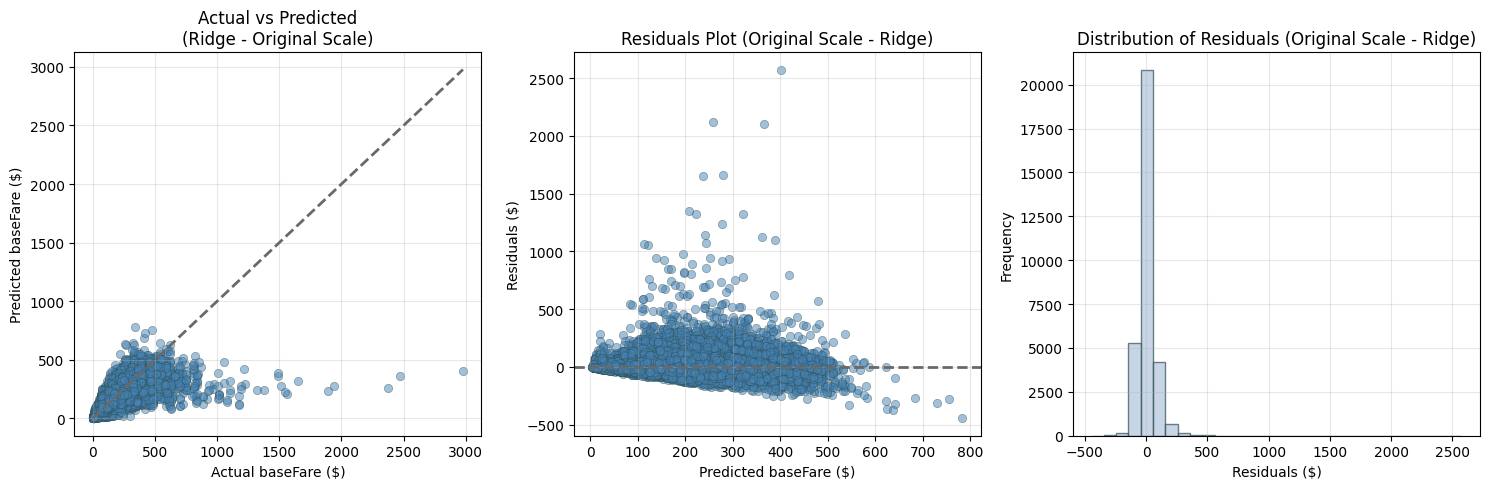

Top 5 absolute errors (Ridge):
26233    2574.604087
17750    2119.942944
774      2102.393273
29395    1659.970997
1689     1655.309319
Name: baseFare, dtype: float64


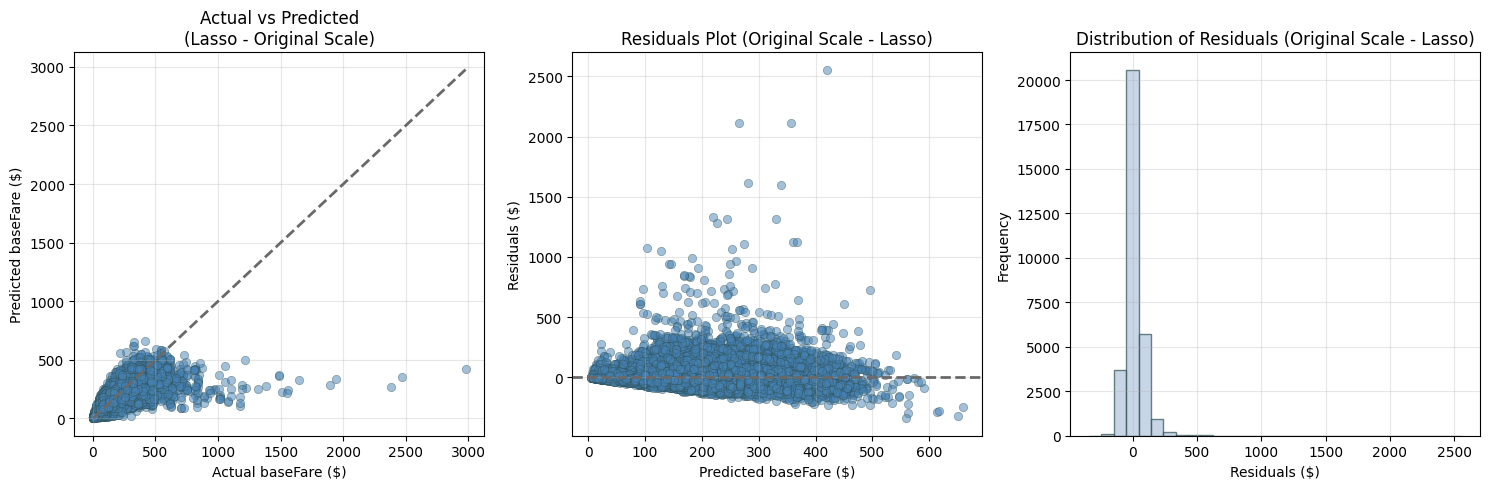

Top 5 absolute errors (Lasso):
26233    2556.422082
17750    2111.824856
774      2111.796217
1689     1611.110575
29395    1599.164737
Name: baseFare, dtype: float64


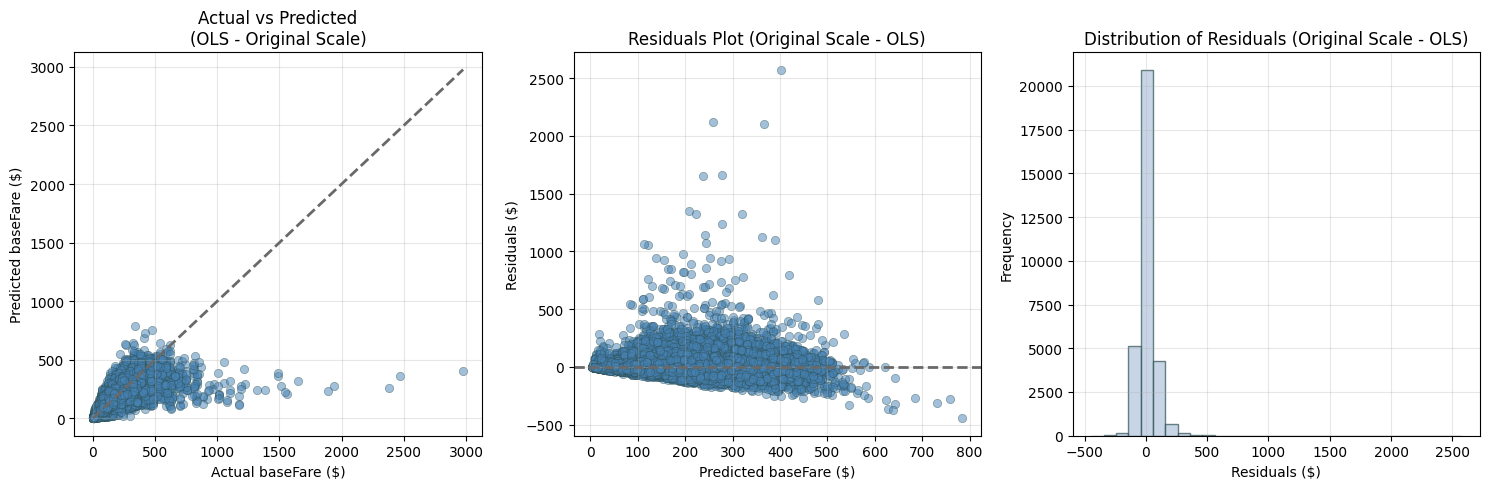

Top 5 absolute errors (OLS):
26233    2574.796991
17750    2119.901483
774      2102.410998
29395    1660.789588
1689     1655.787053
Name: baseFare, dtype: float64


In [35]:

COLOR_POINT = 'steelblue'
COLOR_EDGE  = 'darkslategray'
COLOR_LINE  = 'dimgray'
COLOR_HIST  = 'lightsteelblue'

for model_name, y_pred, residuals in [
    ('Ridge', y_pred_ridge_test, residuals_ridge),
    ('Lasso', y_pred_lasso_test, residuals_lasso),
    ('OLS',   y_pred_ols_test,   residuals_ols)
]:
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.scatter(y_test_actual, y_pred, alpha=0.5, color=COLOR_POINT, edgecolors=COLOR_EDGE, linewidth=0.5)
    min_v, max_v = y_test_actual.min(), y_test_actual.max()
    plt.plot([min_v, max_v], [min_v, max_v], '--', color=COLOR_LINE, lw=2)
    plt.xlabel('Actual baseFare ($)')
    plt.ylabel('Predicted baseFare ($)')
    plt.title(f'Actual vs Predicted\n({model_name} - Original Scale)')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.scatter(y_pred, residuals, alpha=0.5, color=COLOR_POINT, edgecolors=COLOR_EDGE, linewidth=0.5)
    plt.axhline(y=0, color=COLOR_LINE, linestyle='--', lw=2)
    plt.xlabel('Predicted baseFare ($)')
    plt.ylabel('Residuals ($)')
    plt.title(f'Residuals Plot (Original Scale - {model_name})')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, alpha=0.7, edgecolor=COLOR_EDGE, color=COLOR_HIST)
    plt.xlabel('Residuals ($)')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Residuals (Original Scale - {model_name})')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Top 5 absolute errors ({model_name}):")
    abs_errors = np.abs(residuals)
    print(abs_errors.sort_values(ascending=False).head())


### Analysis by Fare Range

- Mean Absolute Error (MAE) per fare range
- Mean Relative Error (%) per fare range (mean(|actual - pred| / actual) * 100, excluding zero actuals)

Ridge Fare Range Performance:


,Fare Range,MAE ($),Mean Rel Error (%),Count
2,0-100 $,28.42,53.13,5920
5,100-200 $,32.93,22.89,13162
8,200-300 $,48.93,20.06,7230
11,300-500 $,85.77,23.30,4642
14,500-1000 $,259.30,41.35,430
17,1000+ $,1108.37,79.78,34



Lasso Fare Range Performance:


,Fare Range,MAE ($),Mean Rel Error (%),Count
0,0-100 $,30.24,59.74,5920
3,100-200 $,32.30,22.54,13162
6,200-300 $,49.81,20.42,7230
9,300-500 $,90.18,24.45,4642
12,500-1000 $,268.65,42.92,430
15,1000+ $,1107.04,79.84,34



OLS Fare Range Performance:


,Fare Range,MAE ($),Mean Rel Error (%),Count
1,0-100 $,28.42,53.12,5920
4,100-200 $,32.93,22.89,13162
7,200-300 $,48.94,20.06,7230
10,300-500 $,85.78,23.30,4642
13,500-1000 $,259.29,41.35,430
16,1000+ $,1108.41,79.78,34


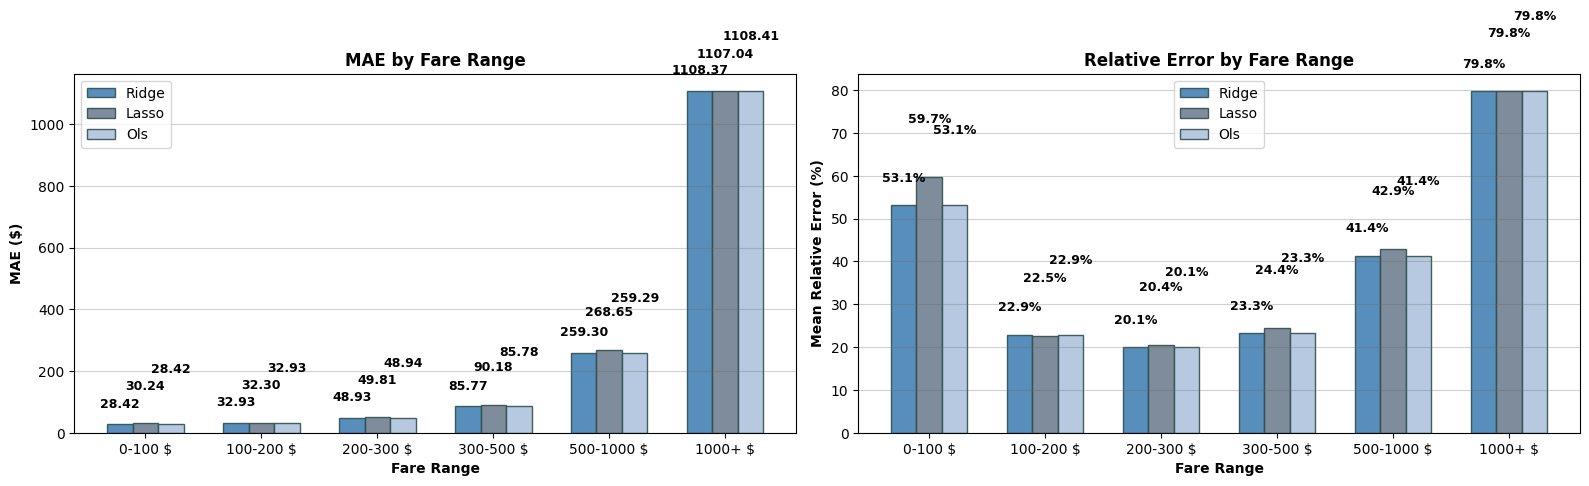

In [51]:
fare_bins = [0, 100, 200, 300, 500, 1000, 3000]
fare_labels = ['0-100 $', '100-200 $', '200-300 $', '300-500 $', '500-1000 $', '1000+ $']

pred_df = pd.DataFrame({
    'actual': y_test_actual,
    'ridge': y_pred_ridge_test,
    'lasso': y_pred_lasso_test,
    'ols':   y_pred_ols_test
})

long_df = pred_df.melt(id_vars='actual', value_vars=['ridge','lasso','ols'], var_name='model', value_name='pred')

long_df['abs_error'] = (long_df['actual'] - long_df['pred']).abs()
non_zero_mask = long_df['actual'] != 0
long_df['rel_error_pct'] = np.where(non_zero_mask, long_df['abs_error'] / long_df['actual'] * 100, np.nan)

long_df['fare_range'] = pd.cut(long_df['actual'], bins=fare_bins, labels=fare_labels, right=True, include_lowest=True)

agg_df = (long_df
          .groupby(['fare_range','model'], observed=True)
          .agg(MAE=('abs_error','mean'), Mean_Relative_Error_pct=('rel_error_pct','mean'), Count=('actual','count'))
          .reset_index())

agg_df[['MAE','Mean_Relative_Error_pct']] = agg_df[['MAE','Mean_Relative_Error_pct']].round(2)

model_tables = {}
for m in ['ridge','lasso','ols']:
    tbl = (agg_df[agg_df['model']==m]
           .drop(columns='model')
           .rename(columns={'fare_range':'Fare Range','MAE':'MAE ($)','Mean_Relative_Error_pct':'Mean Rel Error (%)'})
           [['Fare Range','MAE ($)','Mean Rel Error (%)','Count']])
    model_tables[m] = tbl

print("Ridge Fare Range Performance:")
display(model_tables['ridge'])
print("\nLasso Fare Range Performance:")
display(model_tables['lasso'])
print("\nOLS Fare Range Performance:")
display(model_tables['ols'])



mae_pivot = agg_df.pivot(index='fare_range', columns='model', values='MAE').reindex(fare_labels)
rel_pivot = agg_df.pivot(index='fare_range', columns='model', values='Mean_Relative_Error_pct').reindex(fare_labels)

colors = {'ridge':'steelblue','lasso':'slategray','ols':'lightsteelblue'}
edge_color = 'darkslategray'
models_order = ['ridge','lasso','ols']
bar_width = 0.22
x = np.arange(len(fare_labels))

fig, axes = plt.subplots(1, 2, figsize=(16,5))


max_mae = np.nanmax(mae_pivot.values)
mae_vertical_offsets = [0.04, 0.09, 0.14]  
for i, m in enumerate(models_order):
    axes[0].bar(x + (i - 1)*bar_width, mae_pivot[m], width=bar_width,
                label=m.capitalize(), color=colors[m], edgecolor=edge_color, alpha=0.9)
    for j, v in enumerate(mae_pivot[m]):
        if not np.isnan(v):
            axes[0].text(x[j] + (i - 1)*bar_width, v + max_mae*mae_vertical_offsets[i], f"{v:.2f}",
                         ha='center', va='bottom', fontsize=9, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(fare_labels)
axes[0].set_ylabel('MAE ($)', fontweight='bold')
axes[0].set_xlabel('Fare Range', fontweight='bold')
axes[0].set_title('MAE by Fare Range', fontweight='bold', fontsize=12)
axes[0].grid(axis='y', alpha=0.3, color='dimgray')
axes[0].legend()


max_rel = np.nanmax(rel_pivot.values)
rel_vertical_offsets = [0.06, 0.15, 0.20]
for i, m in enumerate(models_order):
    axes[1].bar(x + (i - 1)*bar_width, rel_pivot[m], width=bar_width,
                label=m.capitalize(), color=colors[m], edgecolor=edge_color, alpha=0.9)
    for j, v in enumerate(rel_pivot[m]):
        if not np.isnan(v):
            axes[1].text(x[j] + (i - 1)*bar_width, v + max_rel*rel_vertical_offsets[i], f"{v:.1f}%",
                         ha='center', va='bottom', fontsize=9, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(fare_labels)
axes[1].set_ylabel('Mean Relative Error (%)', fontweight='bold')
axes[1].set_xlabel('Fare Range', fontweight='bold')
axes[1].set_title('Relative Error by Fare Range', fontweight='bold', fontsize=12)
axes[1].grid(axis='y', alpha=0.3, color='dimgray')
axes[1].legend()

plt.tight_layout()
plt.show()


In [55]:
def build_error_df(actual, predicted):
    df = pd.DataFrame({'actual': actual, 'predicted': predicted})
    df['error'] = df['predicted'] - df['actual'] 
    df['abs_error'] = df['error'].abs()
    return df

error_df_ridge = build_error_df(y_test_actual, y_pred_ridge_test)
error_df_lasso = build_error_df(y_test_actual, y_pred_lasso_test)
error_df_ols   = build_error_df(y_test_actual, y_pred_ols_test)

worst_10_ridge = error_df_ridge.nlargest(10, 'abs_error')[['error','actual','predicted']].round(2)
worst_10_lasso = error_df_lasso.nlargest(10, 'abs_error')[['error','actual','predicted']].round(2)
worst_10_ols   = error_df_ols.nlargest(10,   'abs_error')[['error','actual','predicted']].round(2)

print('Ridge - Worst 10 Predictions')
display(worst_10_ridge)
print('Lasso - Worst 10 Predictions')
display(worst_10_lasso)
print('OLS - Worst 10 Predictions')
display(worst_10_ols)



Ridge - Worst 10 Predictions


,error,actual,predicted
26233,-2574.60,2976.74,402.14
17750,-2119.94,2377.67,257.73
774,-2102.39,2467.91,365.52
29395,-1659.97,1938.60,278.63
1689,-1655.31,1893.02,237.71
28578,-1353.25,1561.86,208.61
7432,-1325.68,1646.51,320.83
29864,-1324.58,1547.91,223.33
23645,-1234.24,1510.70,276.46
29753,-1138.23,1380.47,242.24


Lasso - Worst 10 Predictions


,error,actual,predicted
26233,-2556.42,2976.74,420.32
17750,-2111.82,2377.67,265.85
774,-2111.80,2467.91,356.11
1689,-1611.11,1893.02,281.91
29395,-1599.16,1938.60,339.44
29864,-1329.28,1547.91,218.63
28578,-1317.64,1561.86,244.22
7432,-1315.77,1646.51,330.74
23645,-1284.91,1510.70,225.79
10957,-1127.34,1488.37,361.03


OLS - Worst 10 Predictions


,error,actual,predicted
26233,-2574.80,2976.74,401.94
17750,-2119.90,2377.67,257.77
774,-2102.41,2467.91,365.50
29395,-1660.79,1938.60,277.81
1689,-1655.79,1893.02,237.23
28578,-1353.66,1561.86,208.20
7432,-1325.67,1646.51,320.84
29864,-1324.42,1547.91,223.49
23645,-1233.77,1510.70,276.93
29753,-1138.80,1380.47,241.67


## 10. Feature Importance & Coefficient Sparsity

In these linear models, feature importance is the absolute value of the coefficient after preprocessing.

Visuals:
1) Top absolute coefficients per model.
2) Zero vs non‑zero counts (Lasso sparsity).
3) Coefficient magnitude distributions.



Lasso zero coefficients: 190/295 (64.4%)


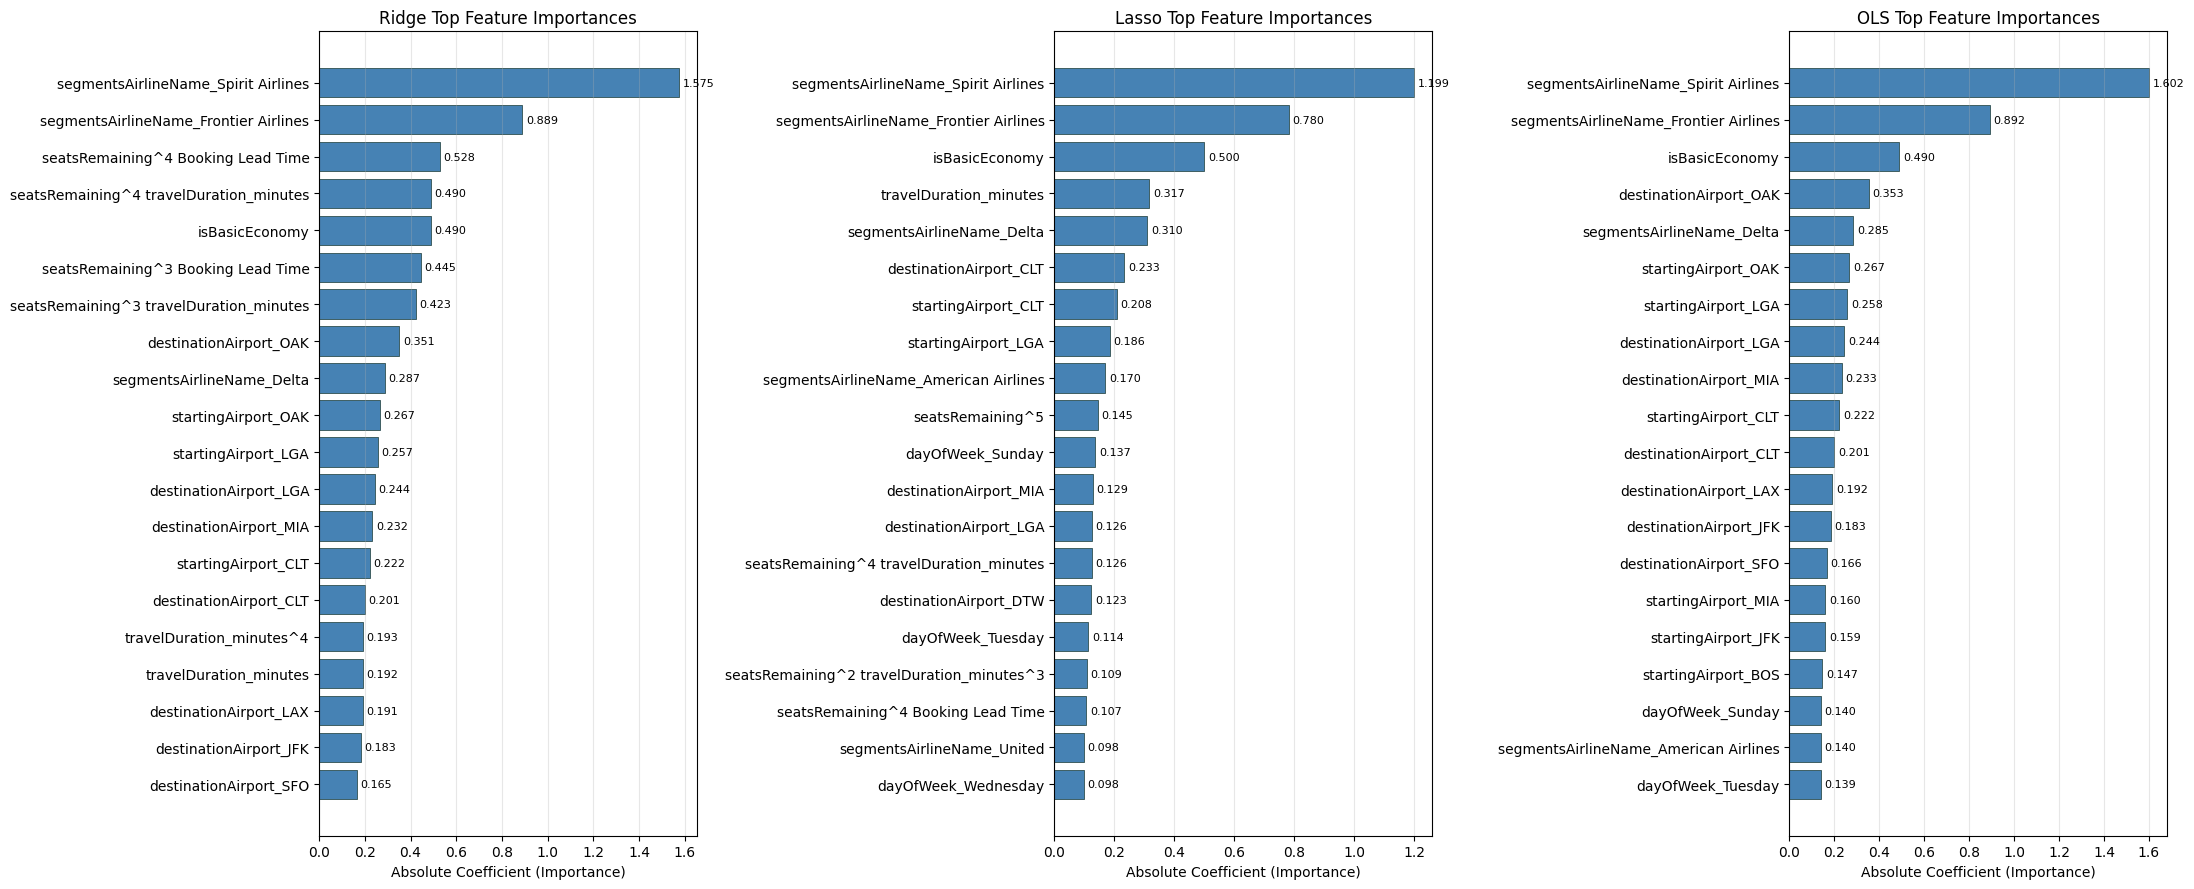

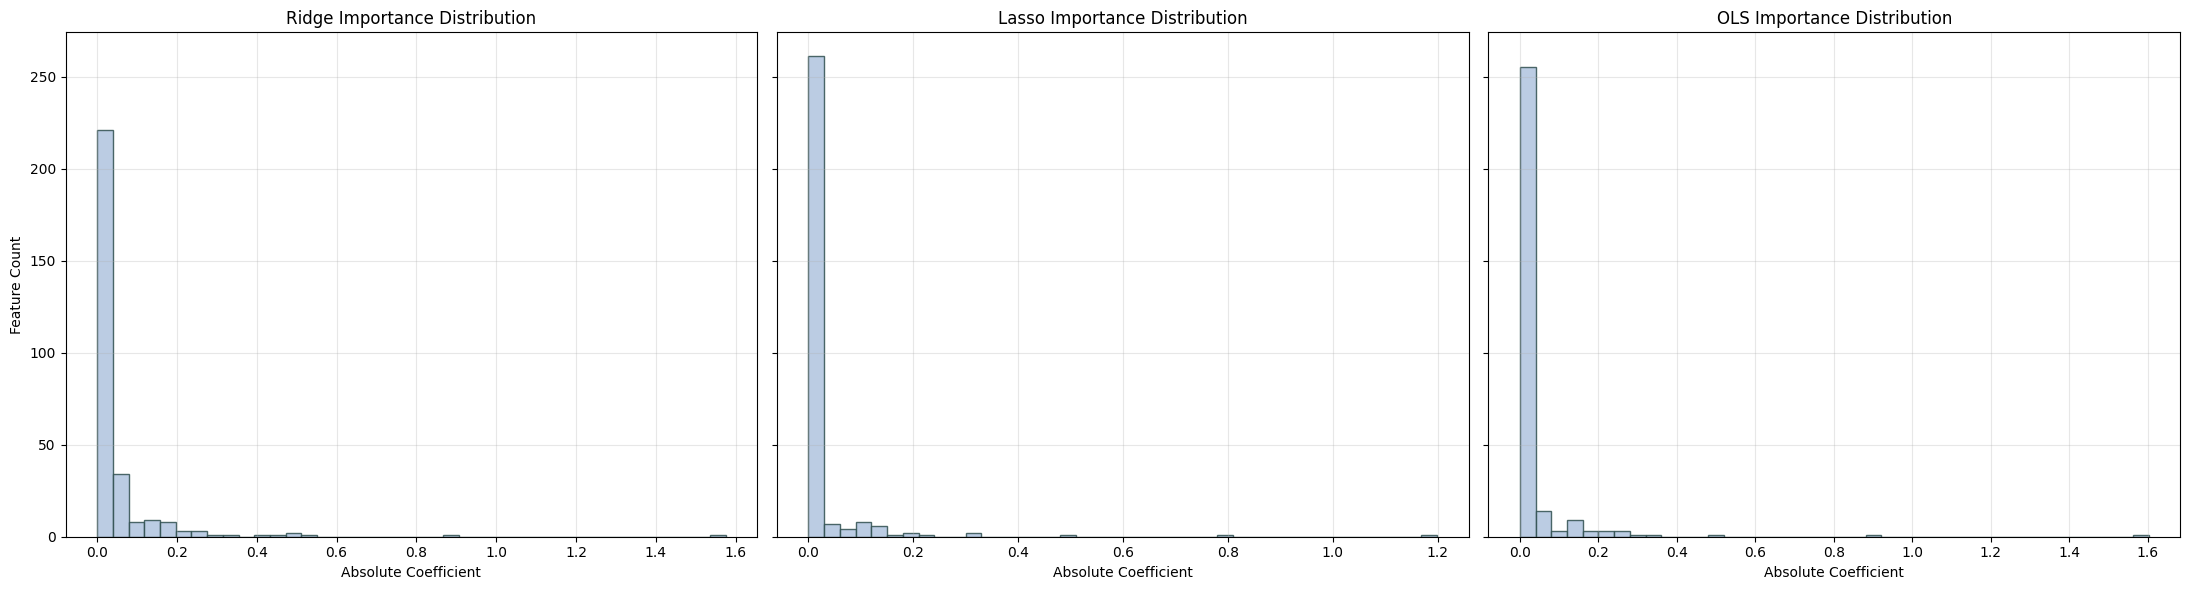

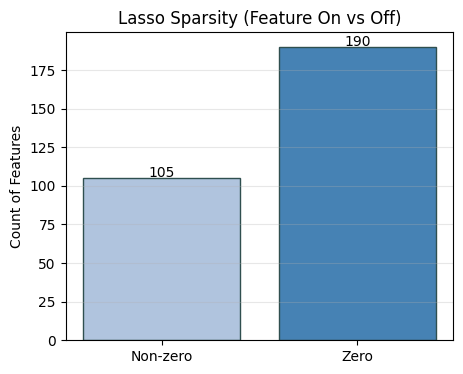

Importance snapshot (first 10 features):
                                 Feature  Ridge_imp  Lasso_imp   OLS_imp
0                         seatsRemaining   0.017584   0.000000  0.002670
1                      Booking Lead Time   0.043270   0.090101  0.017189
2                 travelDuration_minutes   0.191695   0.317008  0.056641
3                      departureTime_sin   0.001799   0.000000  0.002569
4                      departureTime_cos   0.008988   0.018126  0.008282
5                       seatsRemaining^2   0.007245   0.000000  0.000703
6       seatsRemaining Booking Lead Time   0.073334   0.000000  0.022905
7  seatsRemaining travelDuration_minutes   0.050876   0.020640  0.012355
8       seatsRemaining departureTime_sin   0.002319   0.000000  0.000496
9       seatsRemaining departureTime_cos   0.014050   0.000000  0.005067


In [30]:
ridge_coef = final_ridge.named_steps['model'].coef_
lasso_coef = final_lasso.named_steps['model'].coef_
ols_coef = ols_final_pipeline.named_steps['model'].coef_

feature_names = []

poly_transformer = final_ridge.named_steps['preprocessor'].named_transformers_['num']
poly_step = poly_transformer.named_steps['poly']
poly_feature_names = poly_step.get_feature_names_out(continuous_cols)
feature_names.extend(poly_feature_names)

feature_names.extend(binary_cols)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Ridge': ridge_coef,
    'Lasso': lasso_coef,
    'OLS': ols_coef
})

coef_df['Ridge_imp'] = coef_df['Ridge'].abs()
coef_df['Lasso_imp'] = coef_df['Lasso'].abs()
coef_df['OLS_imp'] = coef_df['OLS'].abs()

n_lasso_zero = int((lasso_coef == 0).sum())
n_total = len(lasso_coef)
print(f"Lasso zero coefficients: {n_lasso_zero}/{n_total} ({n_lasso_zero/n_total:.1%})")

TOP_N = 20
ridge_top = coef_df.sort_values('Ridge_imp', ascending=False).head(TOP_N)
lasso_top = coef_df.sort_values('Lasso_imp', ascending=False).head(TOP_N)
ols_top = coef_df.sort_values('OLS_imp', ascending=False).head(TOP_N)

COLOR_BAR = 'steelblue'
EDGE_COLOR = 'darkslategray'


fig, axes = plt.subplots(1, 3, figsize=(22, 9), sharex=False)
for ax, top_df, title, col in zip(
    axes,
    [ridge_top, lasso_top, ols_top],
    ['Ridge Top Feature Importances', 'Lasso Top Feature Importances', 'OLS Top Feature Importances'],
    ['Ridge_imp', 'Lasso_imp', 'OLS_imp']
):
    bars = ax.barh(top_df['Feature'], top_df[col], color=COLOR_BAR, edgecolor=EDGE_COLOR, linewidth=0.6)
    ax.set_title(title)
    ax.invert_yaxis()
    ax.set_xlabel('Absolute Coefficient (Importance)')
    ax.grid(True, axis='x', alpha=0.3)
    for b in bars:
        w = b.get_width()
        if w > 0:
            ax.text(w + max(top_df[col]) * 0.01, b.get_y()+b.get_height()/2, f'{w:.3f}', va='center', fontsize=8)
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(22, 6), sharey=True)
for ax, imp_values, title in zip(
    axes,
    [coef_df['Ridge_imp'], coef_df['Lasso_imp'], coef_df['OLS_imp']],
    ['Ridge Importance Distribution', 'Lasso Importance Distribution', 'OLS Importance Distribution']
):
    ax.hist(imp_values, bins=40, color='lightsteelblue', edgecolor=EDGE_COLOR, alpha=0.85)
    ax.set_title(title)
    ax.set_xlabel('Absolute Coefficient')
    ax.grid(True, alpha=0.3)
axes[0].set_ylabel('Feature Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
plt.bar(['Non-zero', 'Zero'], [n_total - n_lasso_zero, n_lasso_zero], color=['lightsteelblue','steelblue'], edgecolor=EDGE_COLOR)
plt.title('Lasso Sparsity (Feature On vs Off)')
plt.ylabel('Count of Features')
for i,v in enumerate([n_total - n_lasso_zero, n_lasso_zero]):
    plt.text(i, v + 0.5, str(v), ha='center')
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Importance snapshot (first 10 features):")
print(coef_df[['Feature','Ridge_imp','Lasso_imp','OLS_imp']].head(10))


## 11. Model Persistence


In [32]:
os.makedirs('models', exist_ok=True)

models_to_save = {
    'ridge_pipeline.pkl': final_ridge,
    'lasso_pipeline.pkl': final_lasso,
    'ols_pipeline.pkl': ols_final_pipeline
}

for fname, model in models_to_save.items():
    path = os.path.join('models', fname)
    with open(path, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved: {path}")

Saved: models/ridge_pipeline.pkl
Saved: models/lasso_pipeline.pkl
Saved: models/ols_pipeline.pkl
